# 1. Jet Data

In [1]:
import os
import lightning.pytorch as L
from pytorch_lightning.loggers import CometLogger
from lightning.pytorch.callbacks import ModelCheckpoint, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

from utils.configs import ExperimentConfigs
from utils.callbacks import MetricLoggerCallback 
from utils.dataloader import DataloaderModule
from data.particle_clouds.jets import JetDataModule
from multimodal_bridge_matching import MultiModalBridgeMatching

#...Configs 

config = ExperimentConfigs('/home/df630/Multimodal-Bridges/experiments/configs/aoj_config.yaml')

#...Data & model

jets = JetDataModule(config=config, preprocess=True)
dataloader = DataloaderModule(config=config, datamodule=jets)

model = MultiModalBridgeMatching(config)

/home/df630/Multimodal-Bridges/multimodal_bridges/data/particle_clouds/utils.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 8000, validation size: 2000, testing sizes: 0


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [2]:
#...Loggers

if hasattr(config.experiment, 'comet_logger'):
    logger = CometLogger(**config.experiment.comet_logger.to_dict())
    config.experiment.comet_logger.experiment_key = logger.experiment.get_key()
    logger.experiment.log_parameters(parameters=config.to_dict())
else:
    logger = None
    
#...Callbacks (always after loading model and data)

progress_bar = RichProgressBar(theme=RichProgressBarTheme(**config.experiment.progress_bar.to_dict()))
checkpoints = ModelCheckpoint(**config.experiment.checkpoints.to_dict())
metrics = MetricLoggerCallback(sync_dist=True)

CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dfaroughy/multimodal-jets/0f7789cc0e4d439d9138aea38e3dc55f



In [4]:
#...Train

trainer = L.Trainer(
    max_epochs=config.train.max_epochs,
    accelerator="gpu",
    strategy='ddp_notebook',
    num_nodes=1,
    devices=[0,3],
    sync_batchnorm=True,
    gradient_clip_val=1.0,
    callbacks=[progress_bar, checkpoints, metrics],  # Pass all callbacks
    logger=logger,  # Logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:

trainer = L.Trainer(
    max_epochs=config.train.max_epochs,
    accelerator="gpu",
    strategy='ddp_notebook',
    num_nodes=1,
    devices=[0,3],
    sync_batchnorm=True,
    gradient_clip_val=1.0,
    callbacks=[progress_bar, checkpoints, metrics],  # Pass all callbacks
    logger=logger,  # Logger
)




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
        model, train_dataloaders=dataloader.train, val_dataloaders=dataloader.valid
    )


### inspect data

In [2]:
jets.source.continuous.shape, jets.source.discrete.shape, jets.source.mask.shape

(torch.Size([10000, 128, 3]),
 torch.Size([10000, 128, 1]),
 torch.Size([10000, 128, 1]))

In [3]:
jets.target.continuous.shape, jets.target.discrete.shape, jets.target.mask.shape

(torch.Size([10000, 128, 3]),
 torch.Size([10000, 128, 1]),
 torch.Size([10000, 128, 1]))

In [ ]:
jets.source.display_cloud(idx=0, scale_marker=1.0)
jets.target.display_cloud(idx=0, scale_marker=1.0)

### point-cloud feature histograms

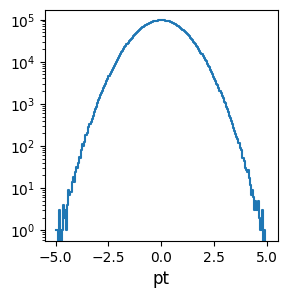

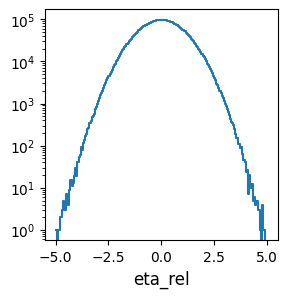

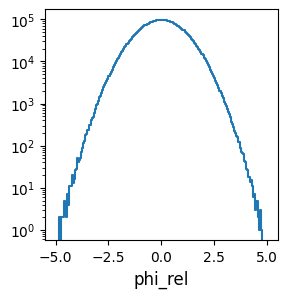

In [ ]:
jets.source.histplot(
    feature="pt", fill=False, binrange=(-5, 5), binwidth=0.05, log_scale=(False, True)
)  # momentum distrbution
jets.source.histplot(
    feature="eta_rel",
    fill=False,
    binrange=(-5, 5),
    binwidth=0.05,
    log_scale=(False, True),
)  # rapidity distrbution
jets.source.histplot(
    feature="phi_rel",
    fill=False,
    binrange=(-5, 5),
    binwidth=0.05,
    log_scale=(False, True),
)  # azimutal angle distrbution


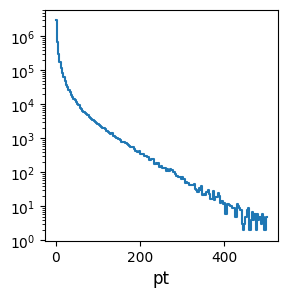

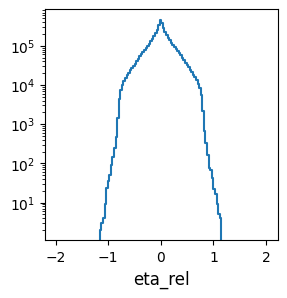

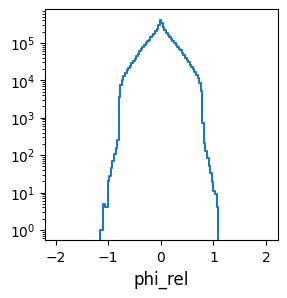

In [ ]:
jets.target.histplot(
    feature="pt", fill=False, binrange=(0, 500), binwidth=3, log_scale=(False, True)
)  # momentum distrbution
jets.target.histplot(
    feature="eta_rel",
    fill=False,
    binrange=(-2, 2),
    binwidth=0.03,
    log_scale=(False, True),
)  # rapidity distribution
jets.target.histplot(
    feature="phi_rel",
    fill=False,
    binrange=(-2, 2),
    binwidth=0.03,
    log_scale=(False, True),
)  # azimuthal angle distribution

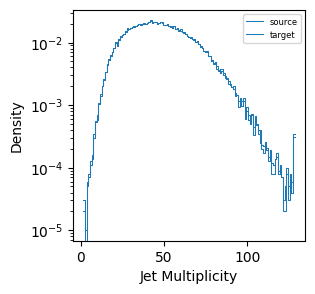

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.histplot(
    jets.source.multiplicity,
    element="step",
    fill=False,
    discrete=True,
    lw=0.75,
    stat="density",
    log_scale=(False, True),
    ax=ax,
    label="source",
)
sns.histplot(
    jets.target.multiplicity,
    element="step",
    fill=False,
    discrete=True,
    lw=0.75,
    stat="density",
    log_scale=(False, True),
    ax=ax,
    label="target",
)
ax.legend(fontsize=6)
ax.set_xlabel("Jet Multiplicity")
plt.show()

In [ ]:
config.data.print()

target:
    name: AspenOpenJets
    path: ['/home/df630/CMB/data/AOJ/2016H_job0.h5', '/home/df630/CMB/data/AOJ/2016H_job1.h5', '/home/df630/CMB/data/AOJ/2016H_job2.h5']
    params:
        min_num_particles: 0
        max_num_particles: 128
        num_jets: 100000
    preprocess:
        continuous: standardize
        discrete: tokens
source:
    name: GaussNoise
    path: None
    params:
        scale: 1.0
        min_num_particles: 0
        max_num_particles: 128
    preprocess:
        continuous: None
        discrete: tokens
dim:
    features_continuous: 3
    features_discrete: 1
    context_continuous: 0
    context_discrete: 0
vocab_size:
    features: 8
    context: 0
